In [1]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import random
from collections import OrderedDict, defaultdict
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from mnist import MNIST, MNISTTrain, MNISTTest
os.environ["CUDA_LAUNCH_BLOCKING"]= "1"
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
plt.style.use("seaborn-v0_8")

In [2]:
batch_size = 1024 * 4
train_loader = DataLoader(dataset=MNISTTrain(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=False)


In [3]:
class EncoderLayer(nn.Module):
    
    def __init__(self, in_dim, hdim, zdim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hdim),
            nn.ReLU(),
            nn.Linear(hdim, hdim),
            nn.LeakyReLU(0.01)
        )
        self.mu_net = nn.Linear(hdim, zdim)
        self.log_sigma_net = nn.Sequential(nn.Linear(hdim, zdim), nn.Softplus()) 
    
    def forward(self, x):
        mlp_out = self.mlp(x)
        mu, log_sigma = self.mu_net(mlp_out), self.log_sigma_net(mlp_out)
        return mu, log_sigma
        
        
class DecoderLayer(nn.Module):
    
    def __init__(self, in_dim, hdim, zdim):
        super().__init__()
        self.zdim = zdim
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hdim),
            nn.ReLU(),
            nn.Linear(hdim, hdim),
            nn.LeakyReLU(0.01)
        )

        self.mu_net = nn.Linear(hdim, zdim)
        self.log_sigma_net = nn.Sequential(nn.Linear(hdim, zdim), nn.Softplus()) 
    
    def forward(self, tb_mu, tb_log_sigma,  bt_mu=None, bt_log_sigma=None):
        eps = torch.randn(tb_mu.size()).to(tb_mu.device).float()
        tb_sigma = tb_log_sigma.exp()
        z = tb_mu + eps * tb_sigma
        
        mlp_out = self.mlp(z)
        tb_mu, tb_log_sigma = self.mu_net(mlp_out), self.log_sigma_net(mlp_out)
        if bt_mu is None:
            assert bt_log_sigma is None
            return tb_mu, tb_log_sigma
        
        tb_sigma = tb_log_sigma.exp()
        bt_sigma = bt_log_sigma.exp()
        
        new_sigma = (tb_sigma.pow(-2) + bt_sigma.pow(-2)).reciprocal().sqrt()
        new_mu = (tb_mu * tb_sigma.pow(-2) + bt_mu * bt_sigma.pow(-2)) * new_sigma.square()
        
        return new_mu, new_sigma.log()
    
    
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.nlayers = 4
        self.layer_z_dim = [64, 32, 16, 8]
        mlp_sizes = [512, 256, 128, 64]
        in_dims = [784] + self.layer_z_dim[:self.nlayers - 1]
        
        self.encoder_layers = nn.ModuleList([EncoderLayer(in_dims[i], mlp_sizes[i], self.layer_z_dim[i])
                                             for i in range(self.nlayers)
                                            ])
    
    def forward(self, x):
        states = [(x, None)]
        for i in range(self.nlayers):
            mu, log_sigma = states[i]
            mu, log_sigma = self.encoder_layers[i](mu)
            states.append((mu, log_sigma))
        return states

   
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.nlayers = 3
        self.layer_z_dim = [16, 32, 64]
        mlp_sizes = list(reversed([512, 256, 128]))
        self.in_dims = [8, 16, 32]
        
        self.decoder_layers = nn.ModuleList([DecoderLayer(self.in_dims[i], mlp_sizes[i], self.layer_z_dim[i]) 
                                             for i in range(self.nlayers)])
        self.decoder_layers_prior = deepcopy(self.decoder_layers)

        self.out = nn.Linear(self.layer_z_dim[-1], 784)
        
        self.prior_param_mu, self.prior_param_log_sigma = nn.Parameter(torch.zeros(1, 8)), nn.Parameter(torch.zeros(1, 8))

    def forward(self, enc_states):
        dec_states = [enc_states[-1]]
        
        model_dec_states = [(self.prior_param_mu.repeat(enc_states[-1][0].size(0), 1),
                             self.prior_param_log_sigma.repeat(enc_states[-1][1].size(0), 1))]
        
        for i in range(self.nlayers):
            # Top Bottom  mu/log_sigma from decoder
            tb_mu, tb_log_sigma = dec_states[-1]
            
            # Bottom Top mu/log_sigma from encoder
            bt_mu, bt_log_sigma = enc_states[self.nlayers - i]
            
            tb_mu, tb_log_sigma = self.decoder_layers[i](tb_mu, tb_log_sigma, bt_mu, bt_log_sigma)
            dec_states.append((tb_mu, tb_log_sigma))
            
            model_mu, model_log_sigma = self.decoder_layers_prior[i](*model_dec_states[-1])
            model_dec_states.append((model_mu, model_log_sigma))
            
            
        eps = torch.randn(tb_mu.size()).to(tb_mu.device).float()
        z = tb_mu + eps * tb_log_sigma.exp()
        x = self.out(z)
        x = F.sigmoid(x)
        return x, dec_states, model_dec_states

    def generate(self):
        model_dec_states = [(self.prior_param_mu, 
                             self.prior_param_log_sigma.cuda())]
        for i in range(self.nlayers):
            model_mu, model_log_sigma = self.decoder_layers_prior[i](*model_dec_states[-1])
            model_dec_states.append((model_mu, model_log_sigma))
        
            
        eps = torch.randn(model_mu.size()).to(model_mu.device).float()
        z = model_mu + eps * model_log_sigma.exp()
        x = self.out(z)
        x = F.sigmoid(x)
        return x, [], model_dec_states


class HierarchicalVAE(nn.Module):
    
    def __init__(self,):
        super().__init__()
        self.nlayers = 4
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        enc_states = self.encoder(x)
        x_hat, dec_states, model_dec_states = self.decoder(enc_states)
        return x_hat, dec_states, model_dec_states

    def generate(self, ):
        return self.decoder.generate()
       

In [4]:

def kl_criterion(μ_1, log_σ_1, μ_2, log_σ_2, epsilon=1e-9):
    # KL of N(μ_1, σ_1) and N(μ_2, σ_2) 
    σ_1, σ_2 = log_σ_1.exp(), log_σ_2.exp()
    D = μ_1.size(-1)
    trace_loss = (σ_1.square() / (σ_2.square() + epsilon)).sum(axis=-1)
    quadratic_loss = ((μ_2 - μ_1).square() / (σ_2.square() + epsilon)).sum(axis=-1)
    det_loss = 2 * (log_σ_2.sum(axis=-1) - log_σ_1.sum(axis=-1))
    
    loss = trace_loss + quadratic_loss - D + det_loss
    return 0.5 * loss

class Criterion(nn.Module):
    def __init__(self, beta_mul = 1.0):
        super().__init__()
        self.beta = beta_mul
    
    def forward(self, x, x_hat, dec_states, model_dec_states):
        cross_entropy_loss = F.binary_cross_entropy(x_hat, x, reduction="none").sum(-1)
        kl_loss = x.new_zeros(x.size(0))
        for i in range(len(dec_states)):
            kl_loss = kl_loss + kl_criterion(*dec_states[i], *model_dec_states[i])
        loss = cross_entropy_loss + self.beta * kl_loss
        return loss.mean()
        

In [5]:
def train():
    model = HierarchicalVAE().cuda()
    criterion = Criterion()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.998) 
    epochs = 50
    losses = []
    it = 0
    for i in range(epochs):
        print("Starting Epoch ", i, "...")
        for j, (img, label) in enumerate(train_loader):
            img = img.cuda()
            img = img.view(img.size(0), -1)
            img /= 255.0
            x_hat, dec_states, model_dec_states = model(img)
            out = x_hat.view(img.size())
            # if i==3 and j == 38:
            #     print(img.max(), out.max(), img.min(), out.min())
            #     raise Exception
            # print(i, j)
            # print(out.size(), img.size())
            loss = criterion(img, out, dec_states, model_dec_states)
            optimizer.zero_grad()
            loss.backward()
            it += 1
            nn.utils.clip_grad_norm_(model.parameters(), 10.)
            optimizer.step()
            losses.append(loss.item())
            if it % 50 == 0:
                print(f"Epoch: {i}, batch: {j}, loss: {np.mean(losses[-100:])}, lr: {scheduler.get_last_lr()[0]:1.5e}")
        scheduler.step()

    return model, losses

In [6]:
model, losses = train()

Starting Epoch  0 ...
Epoch: 0, batch: 49, loss: 322.7875024414063, lr: 2.00000e-03
Starting Epoch  1 ...
Epoch: 1, batch: 40, loss: 280.0739939880371, lr: 1.99600e-03
Starting Epoch  2 ...
Epoch: 2, batch: 31, loss: 218.4723223876953, lr: 1.99201e-03
Starting Epoch  3 ...
Epoch: 3, batch: 22, loss: 191.95337799072266, lr: 1.98802e-03
Starting Epoch  4 ...
Epoch: 4, batch: 13, loss: 181.58531158447266, lr: 1.98405e-03
Starting Epoch  5 ...
Epoch: 5, batch: 4, loss: 176.9297427368164, lr: 1.98008e-03
Epoch: 5, batch: 54, loss: 173.58215225219726, lr: 1.98008e-03
Starting Epoch  6 ...
Epoch: 6, batch: 45, loss: 170.86847442626953, lr: 1.97612e-03
Starting Epoch  7 ...
Epoch: 7, batch: 36, loss: 168.52008071899414, lr: 1.97217e-03
Starting Epoch  8 ...
Epoch: 8, batch: 27, loss: 166.4792481994629, lr: 1.96822e-03
Starting Epoch  9 ...
Epoch: 9, batch: 18, loss: 164.98416732788087, lr: 1.96429e-03
Starting Epoch  10 ...
Epoch: 10, batch: 9, loss: 164.07277450561523, lr: 1.96036e-03
Startin

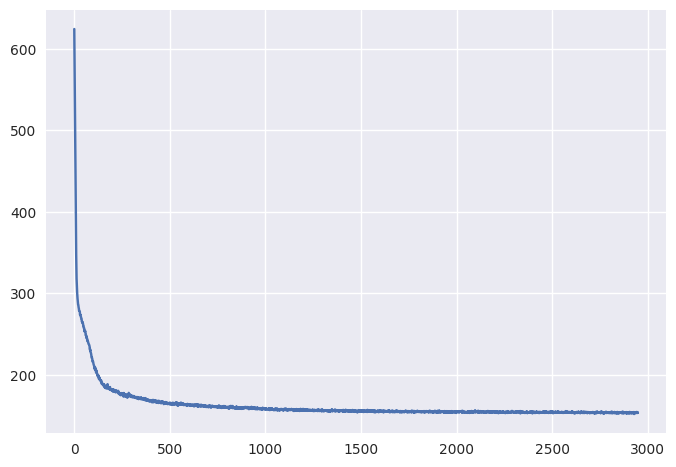

In [7]:
plt.plot(losses)

In [8]:
def plot_images(model, idx, nsamples=1):
    with torch.no_grad():
        model.eval()
        img, label = test_loader.dataset[idx]
        size = img.size(-1)
    
        img = img.unsqueeze(0).cuda()
        img = img.view(img.size(0), -1)
        img /= 255.0
        x_hat, dec_states, model_dec_states = model(img.expand(nsamples, -1))
        out = x_hat.mean(axis=0)
        out = out.view(size, size).detach().cpu()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img.squeeze(0).view(size, size).detach().cpu())
        ax2.imshow(out)
        fig.suptitle(label.item())

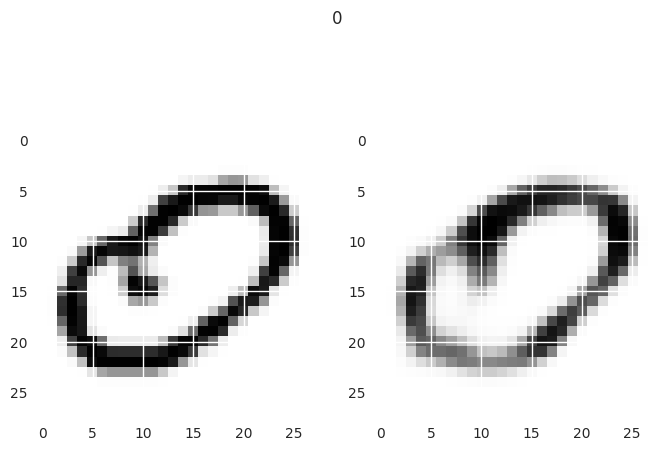

In [9]:
plot_images(model, 0)

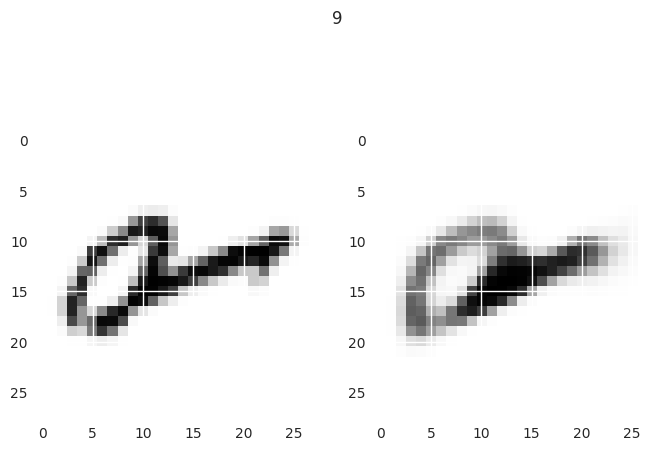

In [10]:
plot_images(model, 100)

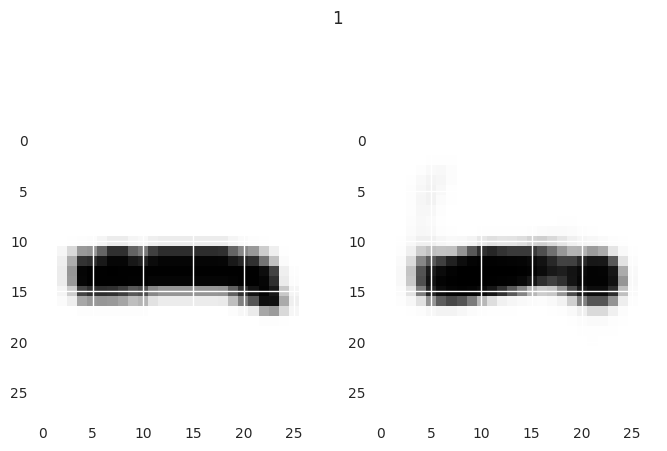

In [11]:
plot_images(model, 333, 1)

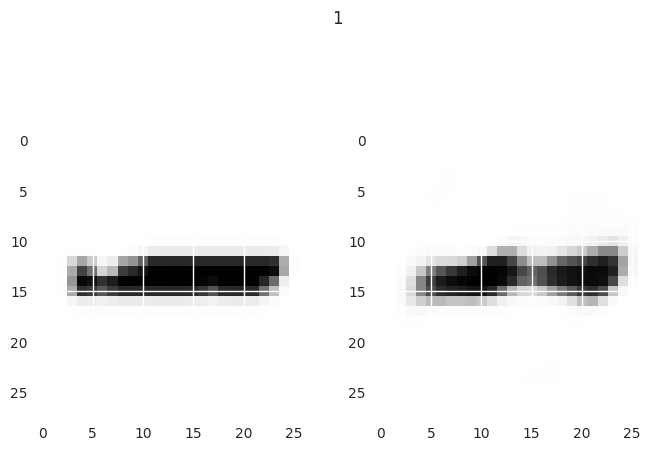

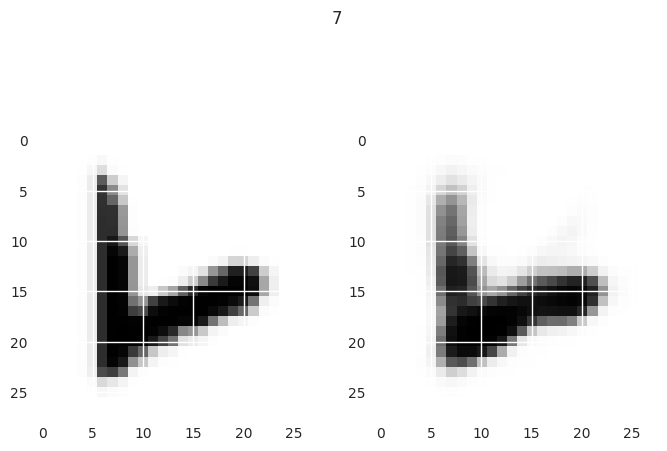

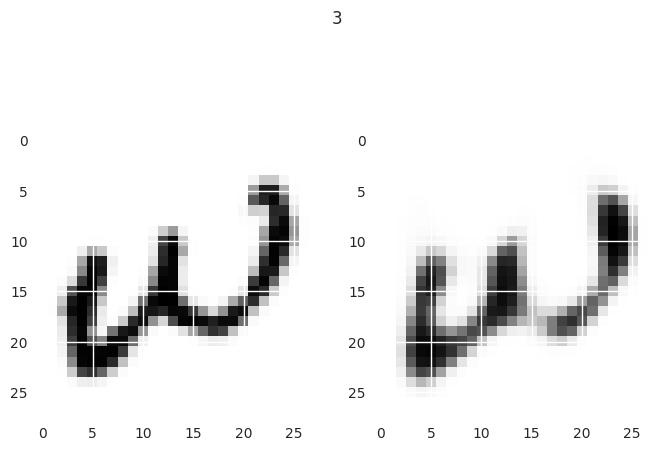

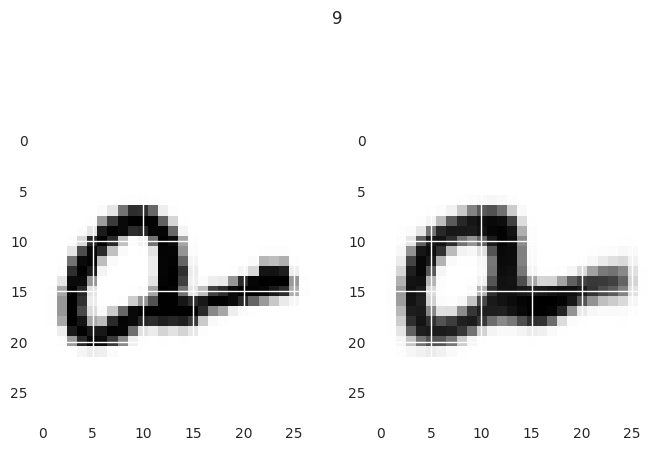

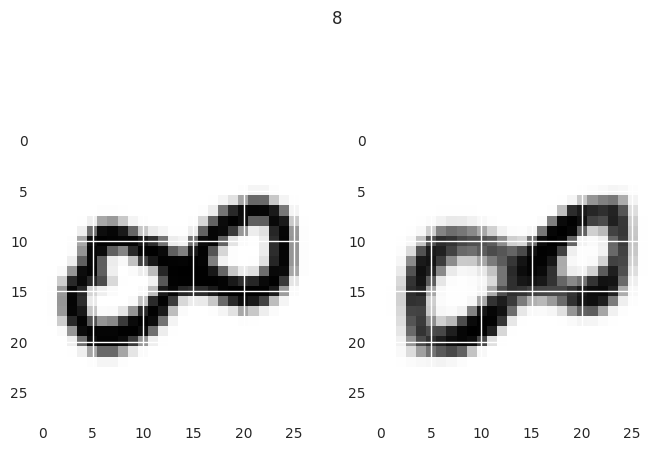

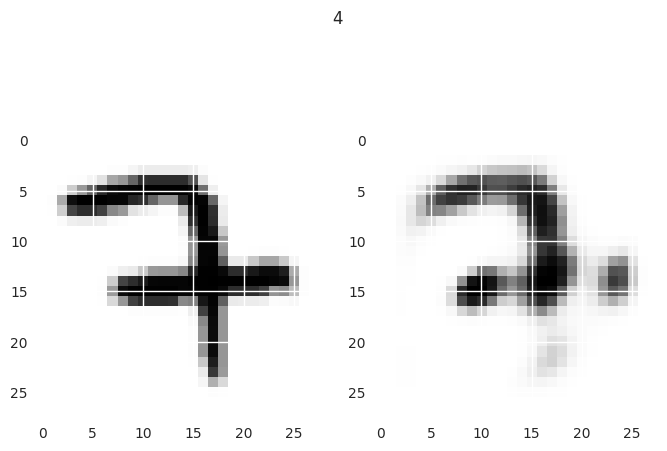

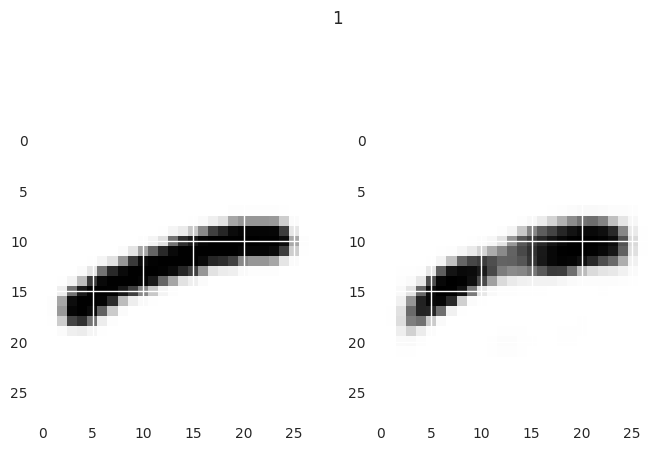

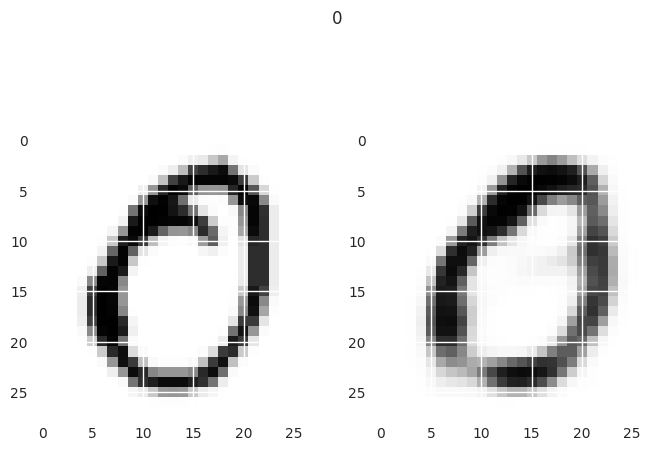

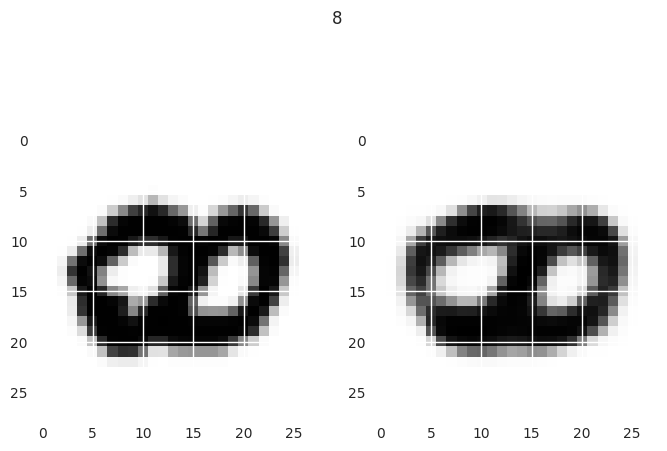

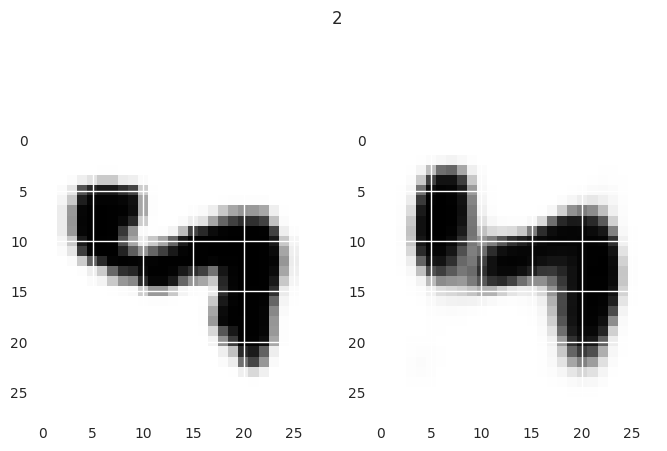

In [12]:
for j in torch.randint(5000, 9999, (10,)):
    plot_images(model, j, 1)

In [13]:
def generate_images(model):
    with torch.no_grad():
        model.eval()
        x_hat, dec_states, model_dec_states = model.generate()
        out = x_hat[0]
        out = out.view(28, 28).detach().cpu()
        fig, ax = plt.subplots()
        ax.imshow(out)

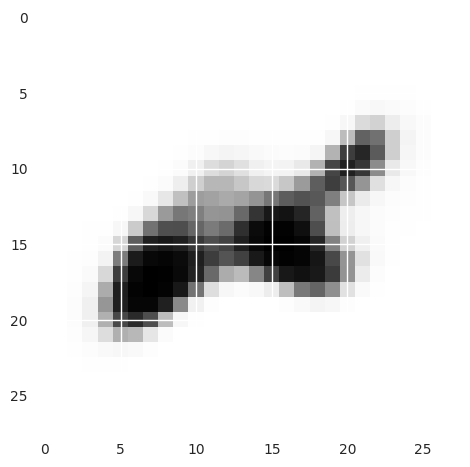

In [14]:
generate_images(model)

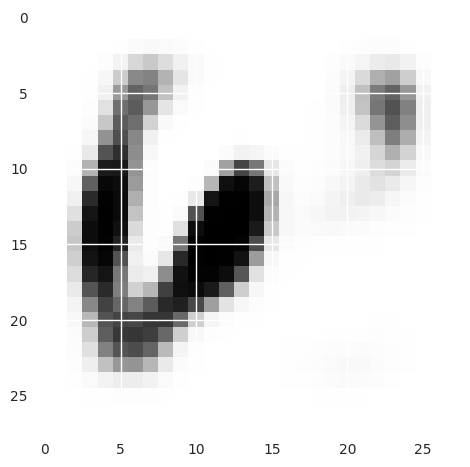

In [15]:
generate_images(model)

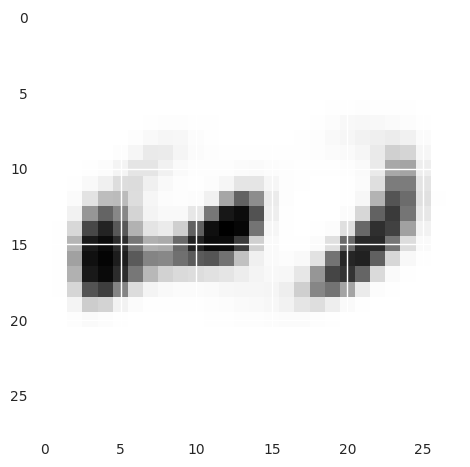

In [16]:
generate_images(model)

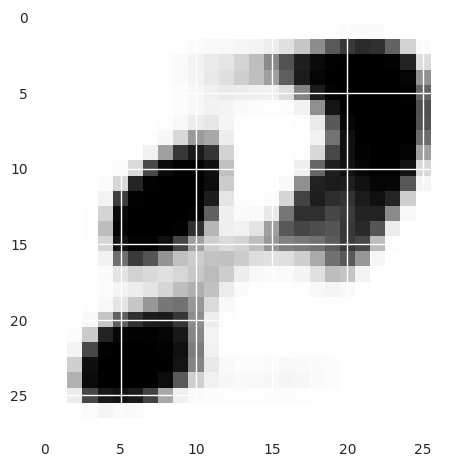

In [17]:
generate_images(model)

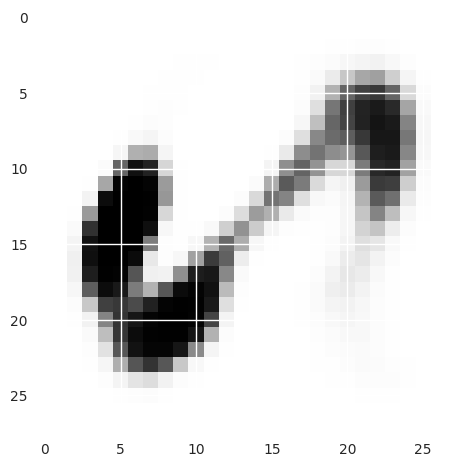

In [18]:
generate_images(model)